# CDSDS 542 Deep Learning for Data Science - Discussion 7: CNN
####  Computer vision libraries in PyTorch
| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. |
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. |
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  |
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iterable over a dataset (created with `torch.utils.data.Dataset`). |    
    

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image as IMAGE
import numpy as np
import requests
from io import BytesIO

!pip install ultralytics opencv-python -q
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.7/772.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 39.1 MB/s eta 0:00:00


### Exercise 1 — Basic Output Size

A 1D convolution layer has:

* Input: 1 channel, length (6)
* Kernel size: (3)
* Stride: (1)
* Padding: (0)
* Number of output channels: (2)

**(a)** How many output values does each output channel produce?

**(b)** If channel-1’s kernel is $(w_1,w_2,w_3)$ and inputs are $x_1,\dots,x_6$, write the formula for the first output value $h_1^{(1)}$ of channel 1?


**Solution**:<br>
(a) (6 - 3 + 2*0)/1 = 4 <br>Each output channel produces 4 output values.<br>

(b) $h_1^{(1)}$ = $w_1*x_1 + w_2*x_2 + w_3*x_3$







---

### Exercise 2 — Parameter Count

A 2D convolution layer takes:

* Input: 3 channels, RGB
* Output: 16 channels
* Kernel size: $3\times3$
* Bias term per **output channel**.

Find the total number of learnable parameters (including biases).
(Hint: each output channel has 3×3×3 = 27 weights + 1 bias)





**Solution**:<br>
Total parameters=(Kernel height×Kernel width×Input channels+1)×Output channels<br>
Total parameters=(3×3×3×16)+16=432+16=448<br>









---


![example of going through the different parameters of a Conv2d layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

*Example of what happens when you change the hyperparameters of a `nn.Conv2d()` layer.*
![title](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif)

#### Typical CNN framework
![title](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-4-59-29-pm.png)


In Practice a CNN will learn the values of these filters on its own, during the training process. We need to define the parameters of `nn.Conv2d()`:

* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution. (Number of filters)
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. We can add extra pixels around the edges of the input image to make sure the filter properly passes over the edges of the image. A feature of zero padding is that it will allow us to control the spatial size of the output volumes. Used when its required to preserve the spatial size of the input volume so the input and output width and height are the same. Default: 0.

### Convolution Layers

In [2]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
tensor = torch.randn(1, 3, 64, 64)
output = conv_layer(tensor)
print(conv_layer)
print(output.size())
print()

conv_layer_2 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1)
output_2 = conv_layer_2(tensor)
print(conv_layer_2)
print(output_2.size())

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 16, 64, 64])

Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
torch.Size([1, 16, 32, 32])


### Pooling Layers

Pooling layer downsamples the volume spatially, independently in each depth slice of the input volume. Left: In this example, the input volume of size [224x224x64] is pooled with filter size 2, stride 2 into output volume of size [112x112x64]. Notice that the volume depth is preserved. Right: The most common downsampling operation is max, giving rise to max pooling, here shown with a stride of 2. That is, each max is taken over 4 numbers (little 2x2 square).
![title](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png?w=988)

In [3]:
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
output_3 = max_pool_layer(tensor)
print(tensor.shape)
print(max_pool_layer)
print(output_3.size())

torch.Size([1, 3, 64, 64])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 3, 32, 32])


The function of Pooling is to progressively reduce the spatial size of the input representation.
* It reduces the amount of parameters and computation in the network, and hence to also control overfitting.
* It makes the detection of features invariant to small transformations, distortions and translations. (a small distortion in input will not change the output of Pooling – since we take the maximum / average value in a local neighborhood).
![title](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-6-11-53-pm.png)

### Build a Simple CNN

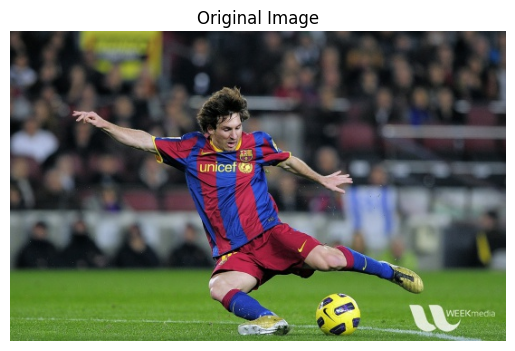

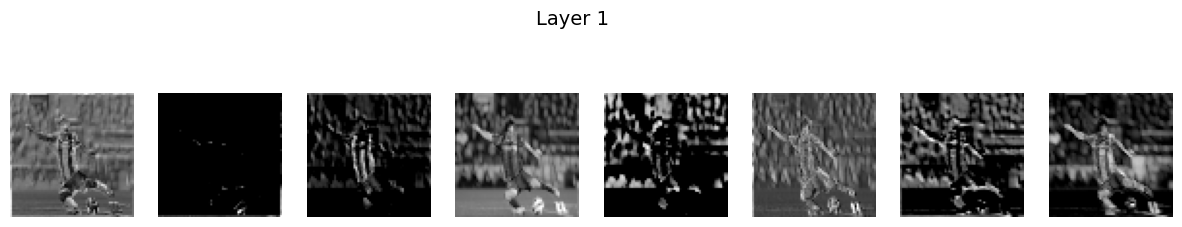

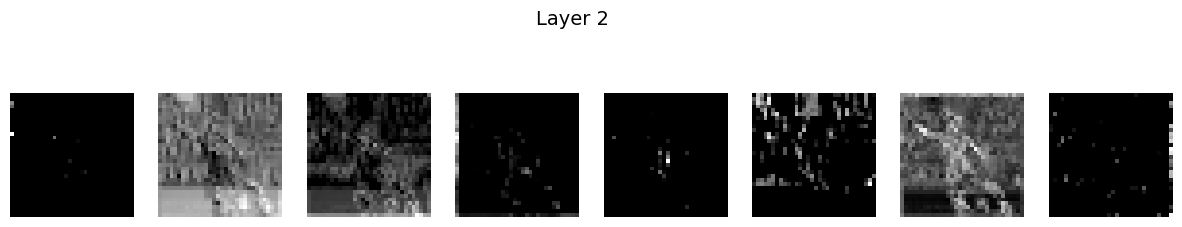

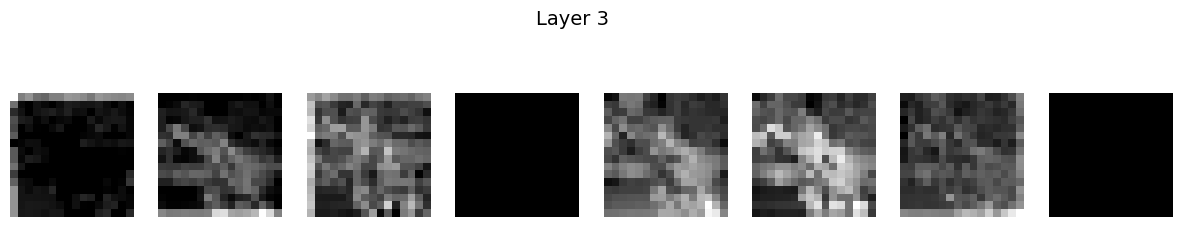

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        return out1, out2, out3

# load sample image
response = requests.get("https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg")
img = IMAGE.open(BytesIO(response.content)).convert("RGB")
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])
x = transform(img).unsqueeze(0)

# forward pass
model = SimpleCNN()
with torch.no_grad():
    out1, out2, out3 = model(x)

# visualize layer outputs
def visualize(tensor, title, n=8):
    tensor = tensor.squeeze(0)
    tensor = tensor.detach().cpu().numpy()
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    fig.suptitle(title, fontsize=14)
    for i in range(n):
        axes[i].imshow(tensor[i], cmap='gray')
        axes[i].axis('off')
    plt.show()


plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()
visualize(out1, "Layer 1")
visualize(out2, "Layer 2")
visualize(out3, "Layer 3")


### Load pre-trained Model and try an object detection task

In [7]:
!pip install ultralytics opencv-python -q

In [8]:
# Load YOLO model
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
print("Model loaded successfully")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model loaded successfully



0: 416x640 1 person, 1 sports ball, 40.3ms
Speed: 1.7ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


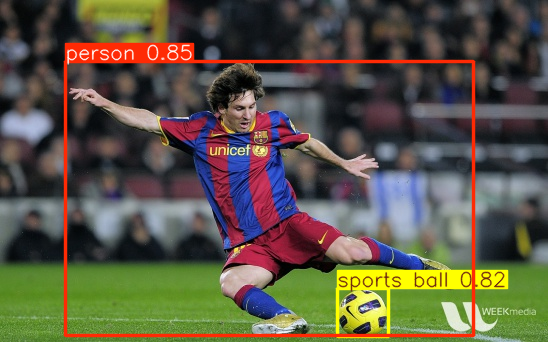

In [10]:
# detection on image above
response = requests.get("https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg")
img = np.array(IMAGE.open(BytesIO(response.content)).convert("RGB"))
results = model.predict(source=img, imgsz=640, conf=0.5)
annotated = results[0].plot()

# Object Detection
from google.colab.patches import cv2_imshow
cv2_imshow(annotated[:, :, ::-1])

# if not using google.colab, replace cv2_imshow as matplotlib here:
# plt.imshow(annotated[:, :, ::-1])
# plt.axis('off')
# plt.show()

### **Also, if you are running on a google browser, you can try it on the webcamera.**

In [11]:
# try with webcam if you are using google browser
def capture_image():
    js = Javascript('''
        async function takePhoto() {
            // Remove any existing capture divs
            const existingDivs = document.querySelectorAll('.capture-container');
            existingDivs.forEach(div => div.remove());

            const div = document.createElement('div');
            div.className = 'capture-container';
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const button = document.createElement('button');
            button.textContent = 'Capture Photo';
            button.style.cssText = 'padding: 10px 20px; font-size: 16px; margin-top: 10px;';
            div.appendChild(button);

            await new Promise((resolve) => button.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(t => t.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')
    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])
    img_array = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img

**Example:**

📸 Please allow camera & click 'Capture Photo'


<IPython.core.display.Javascript object>


0: 480x640 1 person, 102.1ms
Speed: 0.9ms preprocess, 102.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

Detection Results:


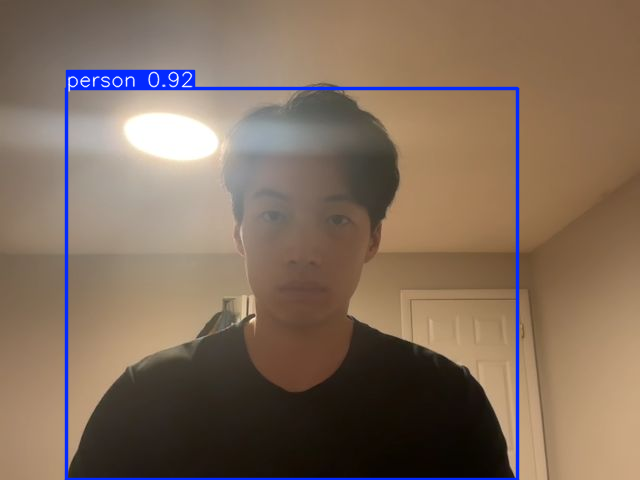


Press [Enter] to capture again or type 'q' to quit: q
Detection stopped.


In [13]:
while True:
    print("📸 Please allow camera & click 'Capture Photo'")
    frame = capture_image()
    results = model.predict(frame, imgsz=640, conf=0.5)
    annotated = results[0].plot()

    print("\nDetection Results:")
    cv2_imshow(annotated)
    cont = input("\nPress [Enter] to capture again or type 'q' to quit: ")
    if cont.lower() == 'q':
        break
    print("\n" + "="*50 + "\n")

print("Detection stopped.")

### End of Discussion